In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import regex

from tqdm import tqdm

In [2]:
from src import utils,physics
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Potential
from src.constants import G,Msun,kpc,Myr,Gyr,cross_section,km,second

## Constants and general functions

In [3]:
# Mtot = 1.0e10 * Msun #Default halo mass in solar masses (Msun).
# Rs = 2.68441 * kpc #kpc
# c = 17
Mtot_dm = 1.15e9 * Msun
Mtot_b = 1e5 * Msun
Rs = 1.18 * kpc
c = 19
# sigma = 50 * cross_section
sigma = 0

## Setup

In [4]:
n_particles = int(1e5)
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_dm/n_particles)
density = Hernquist(Mtot=Mtot_b,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_b/n_particles)
density.Tdyn = dm_density.Tdyn
steps_per_Tdyn = 1000
total_run_time = 1100 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=sigma,save_every=save_every,
                  total_run_time=total_run_time)
halo.add_background(Potential.from_files(halo.lattice,Mtot=Mtot_dm,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12550000,tfinal=1100,
                                         max_time=19.605*Gyr))

Load files: 100%|███████████████████████████████████████████████████████| 251/251 [00:00<00:00, 981.54it/s]


In [5]:
# halo.reset()
halo.evolve(n_Tdyn=1100)
# halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|█████████████████████████████████████████████████████████| 1100000/1100000 [1:50:44<00:00, 165.56it/s]


In [6]:
halo.saved_states.to_csv('states.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

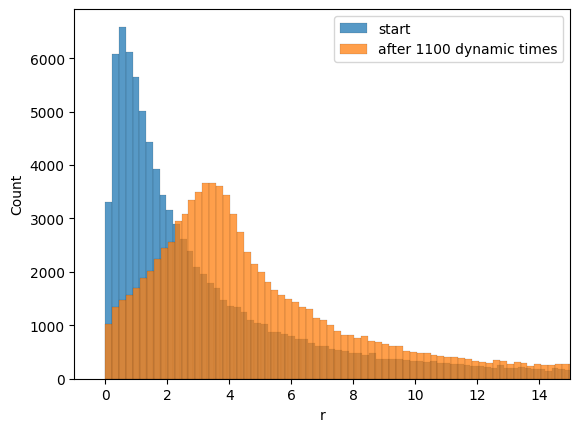

In [11]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

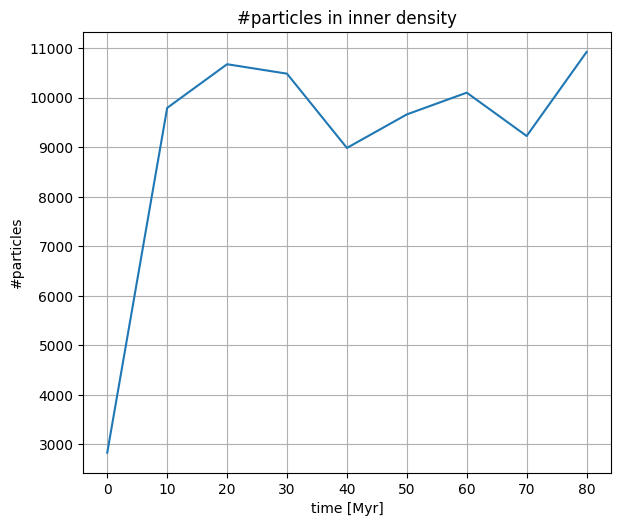

In [21]:
halo.plot_inner_core_density();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


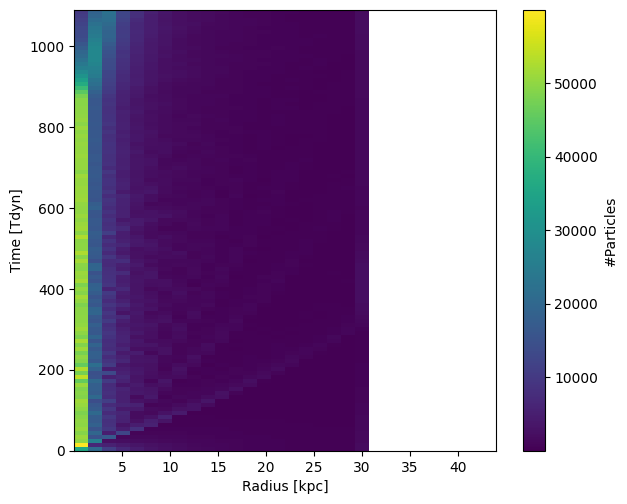

In [7]:
halo.plot_density_evolution();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


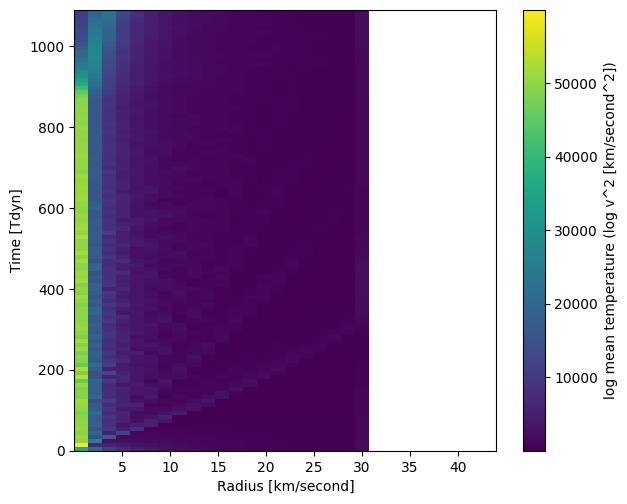

In [8]:
halo.plot_temperature();

In [40]:
def prep_2d_data(data,radius_cutoff,x_units,time_units,Tdyn=None,agg_fn='count',n_posts=50):
    if time_units['name'] == 'Tdyn':
        data['time'] /= Tdyn
    else:
        data['time'] /= time_units['value']
    data = data[data['r'] < radius_cutoff].copy()
    lattice = Lattice(n_posts=n_posts,start=data.r.min(),end=data.r.max()*1.1,log=False)
    data['bin'] = lattice.posts[lattice(data.r.to_numpy())]
    agg_data = data.groupby(['time','bin']).output.agg(agg_fn).reset_index()
    r,time = np.meshgrid(lattice.posts,data.time.unique())
    pad = pd.DataFrame({'time':time.ravel(),'bin':r.ravel()})
    pad['output'] = np.nan
    agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])
    agg_data['bin'] /= x_units['value']
    extent=(r.min()/kpc,r.max()/kpc,time.min(),time.max())
    return agg_data.output.to_numpy().reshape(r.shape),extent

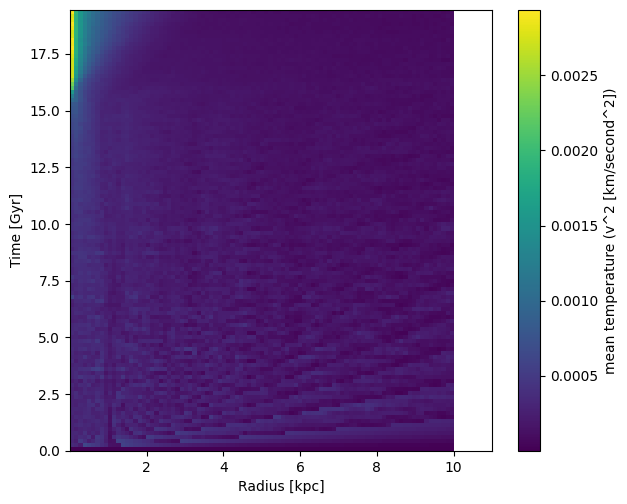

In [64]:
from src.constants import default_units
data = halo.saved_states.copy()
data['output'] = data.v_norm**2
# time_units = default_units('tdyn')
velocity_units = default_units('velocity')
time_units = {'value':Gyr,'name':'Gyr'}
grid,extent = prep_2d_data(data,radius_cutoff=10*kpc,x_units=default_units('length'),time_units=time_units,Tdyn=halo.Tdyn,agg_fn='mean',n_posts=100)

utils.plot_2d(grid,extent=extent,x_units=default_units('length'),y_units=time_units,x_nbins=None,y_nbins=None,
              # xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='#Particles');
              cbar_units={'value':1,'name':f'{velocity_units['name']}^2'},
              xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='mean temperature (v^2 [{name}])');

# Results:

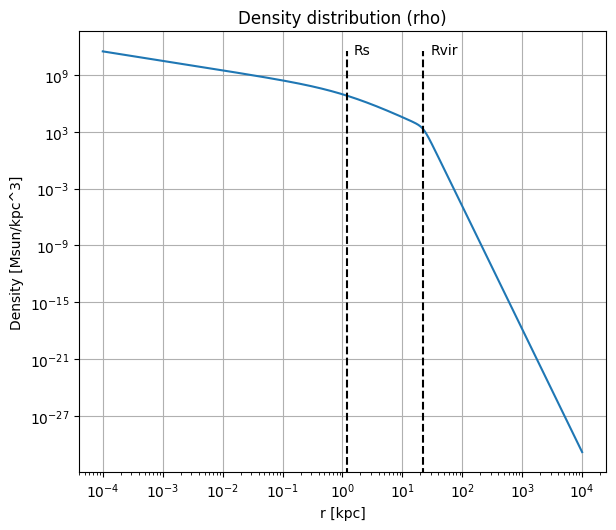

In [9]:
halo.initial_density.plot_rho();

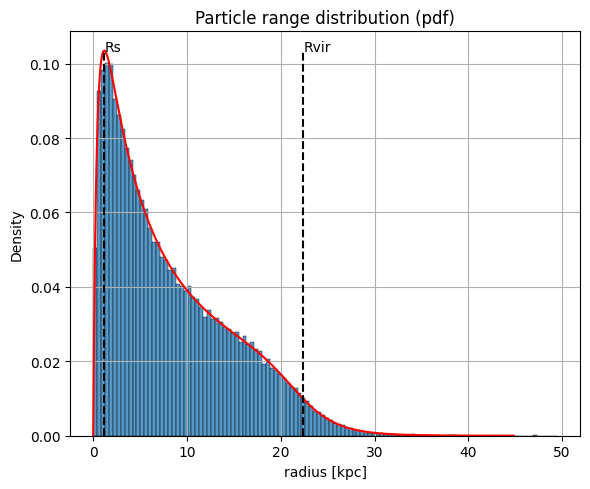

In [5]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False);

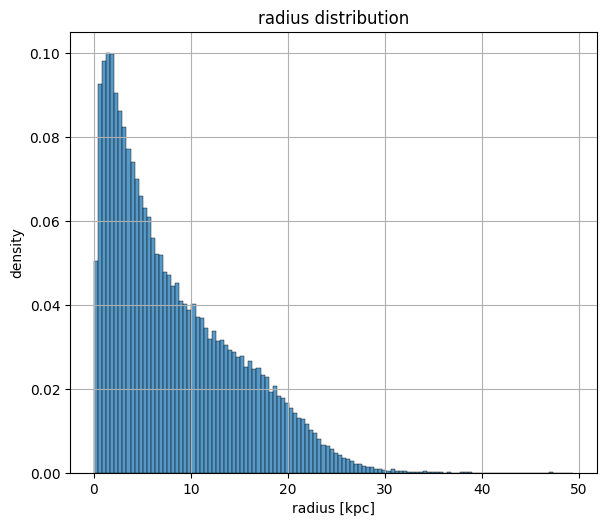

In [6]:
halo.plot_distribution('r',halo.initial_particles);

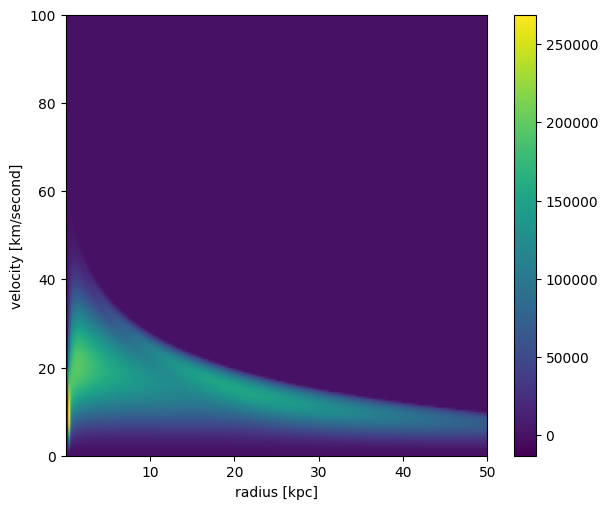

In [7]:
halo.initial_density.plot_phase_space();

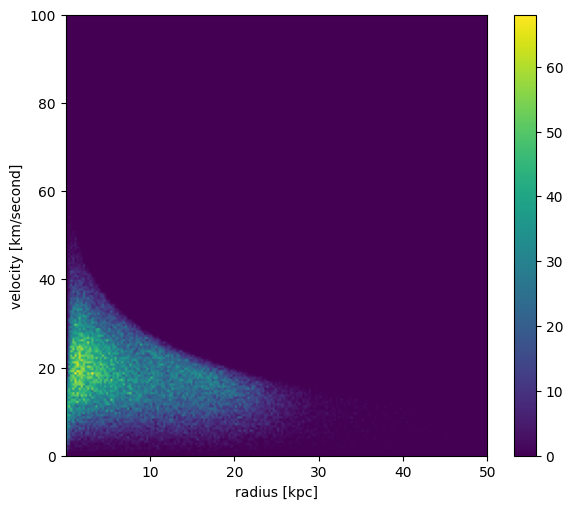

In [8]:
halo.plot_phase_space(halo.initial_particles);